# Deep learning text classification

In this example, we'll take a look at deep-learning text classification.
First, load the required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import xlsxwriter as xlw
import os
import html
import re
import seaborn as sb
import tensorflow as tf
import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import json
import gzip
import math
import warnings
warnings.filterwarnings('ignore')

Next, load the data to use:

In [2]:
# read gz file
# dataset found here http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
data = pd.read_json("C:\\Users\\kelvi\\Desktop\\reviews_Musical_Instruments_5.json.gz", lines=True)

# select the relevant categories for text and how we want to try and train NLP ml
data = data[['reviewText', 'overall']]

We'll define some custom functions below:

In [3]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    fig, (ax,ax1) = plt.subplots(1,2)

    ax.plot(x, acc, 'b', label='Training acc')
    ax.plot(x, val_acc, 'r', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()
    ax1.plot(x, loss, 'b', label='Training loss')
    ax1.plot(x, val_loss, 'r', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.legend()
    
    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)

# apply a text cleaning function to column reviewText
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # make lower case
    text = text.lower()
    
    return text.strip()

# make a custom function which says whether a rating is positive or negative
def review_rating(value):
    if value['overall'] > 3: # a rating of 4 stars or more is viewed as "positive"
        return 1
    elif value['overall'] < 3:
        return 0
    else:
        return 2

In [4]:
# Now, run these functions
data['reviewText'] = data['reviewText'].apply(clean)
data['type'] = data.apply(review_rating,axis=1)

# filter as needed
# we'll remove the 3 star removes as they're not very helpful to say without investigation as to whether it is positive or negative
data = data[data['type']!=2]

# let's get a breakdown of our dataset so we know how it is comprised
type_counts = data['type'].value_counts()

# this is quite one-sided, let's remove most of the positive to make the dataset more even
data_pos = data[data['type']==1]
data_neg = data[data['type']==0]

data_pos = data_pos[1:800]

data = pd.concat([data_pos,data_neg],axis=0)

Let's get the data into the train/test formats:

In [5]:
#class_names=sorted(pd.Series(data['type']).drop_duplicates().tolist())

data_y = data['type']
data_x = data['reviewText']

X_test1 = data['reviewText']

sentences_train, sentences_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=1000)

Get the data ready for the keras model...

In [6]:
# get data ready for keras model

# tokenize data into format that can be used by word embeddings
tokenizer = Tokenizer(num_words=5000) # set size of vocabulary corpus
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_test1 = tokenizer.texts_to_sequences(X_test1)

vocab_size = len(tokenizer.word_index) + 1 # most comment num_words are kept

maxlen = 200 # this cuts sequencs of text which exceed this number

# padding simply pads the sequences of words with zeroes (if text less than maxlen)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

clear_session() # to remove any pre-loaded computed weights, for deep learning model

In [7]:
# load/configure the model

embedding_dim = 50

# the sequential model is a linear stack of layers
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, # size of the vocabulary
                           output_dim=embedding_dim, # size of the dense vector
                           input_length=maxlen)) # length of the sequence
model.add(layers.GlobalMaxPool1D()) # a way to downsample/reduce the size of incoming feature vectors
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', # the learning process is configured with the .compile method
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# get a model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           332800    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 333,321
Trainable params: 333,321
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit the model
history = model.fit(X_train, y_train,
                    epochs=15,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10) # how many samples used in each epoch

In [10]:
# get the model accuracy
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8360


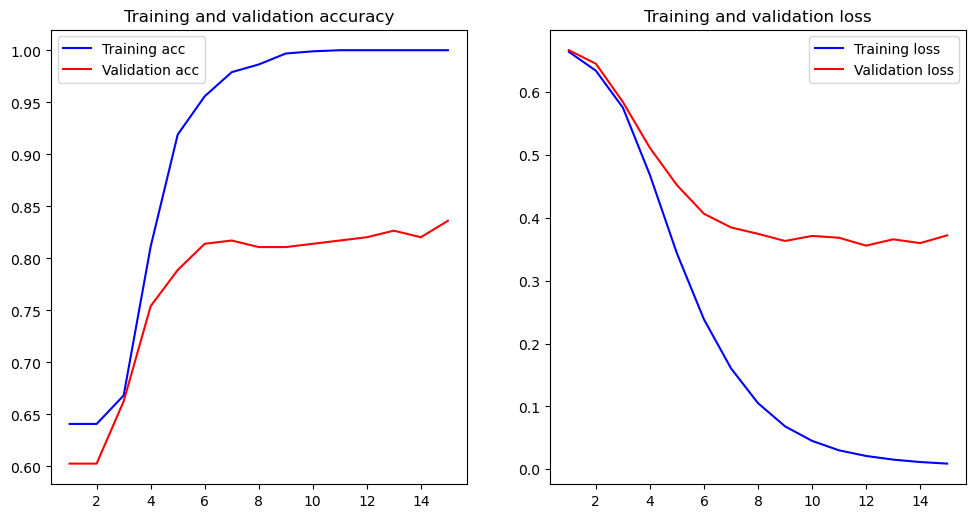

In [11]:
# plot the model performance
plot_history(history)

Here we can see after about epoch 8 the training data becomes overfitted. We can compare this performance to a CNN model below.

In [12]:
clear_session() # to remove any pre-loaded computed weights, for deep learning model

######################## CNN model ###############################
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           332800    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 366,229
Trainable params: 366,229
Non-trainable params: 0
__________________________________________________

In [13]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8233


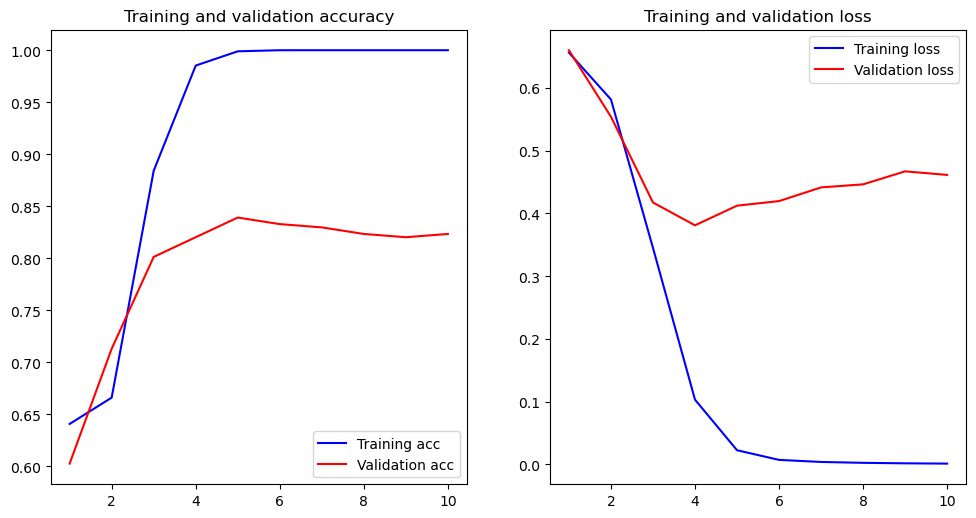

In [14]:
plot_history(history)

The CNN model seems to perform better - it overfits around epoch 4 onwards.

We can also compare performance against a CNN with hyperparameter adjustments.

# Hyperparameter adjustments

In [15]:
clear_session() # to remove any pre-loaded computed weights, for deep learning model

############## cv search #########################
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[200])

# configure the model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 10
embedding_dim = 200
maxlen = 200

model1 = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)

Fit the model

In [16]:
grid = RandomizedSearchCV(estimator=model1, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=4)

grid_result = grid.fit(X_train, y_train)

best_score = grid_result.best_score_

best_params = grid_result.best_params_

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)


print("Testing accuracy of: "+str(test_accuracy))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Testing accuracy of: 0.801261842250824


This score should be compared to the CNN score above, as it is then directly comparing the same model performances. The difference here is that customised hyperparameters have been tested - resulting in slightly worse testing accuracy. This can be because the parameter range(s) chosen are not sufficient for improved model performance. Adjusting the parameter ranges may yield better model performance.